# Evaluate the Performance of MPNN models
Get all of the models, regardless how we trained them and evaluate their performance

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn import metrics
from tqdm import tqdm
from glob import glob
import pandas as pd
import numpy as np
import json
import os

## Find the Models and Summarize Them
There are `best_model.h5` files in subdirectories that contain data on their configuration.

In [2]:
models = glob(os.path.join('**', 'test_predictions.csv'), recursive=True)
print(f'Found {len(models)} models')

Found 35 models


In [3]:
def generate_summary(path):
    """Generate the summary of a model, given path to its output
    
    Args:
        path (str): Path ot the trained weights
    Returns:
        (dict) Model information
    """
    
    # Store the directory first
    dir_name = os.path.dirname(path)
    output = {'path': dir_name}
    
    # Get the host and run parameters
    for f in ['host_info.json', 'run_params.json']:
        with open(os.path.join(dir_name, f)) as fp:
            output.update(json.load(fp))
            
    # Compute the number of nodes
    output['n_nodes'] = output['total_ranks'] // output['ranks_per_node'] \
        if 'total_ranks' in output else 1
    
    # Convert the start time to a datetime
    output['start_time'] = datetime.fromisoformat(output['start_time'])
            
    # Get the log infomration
    log_file = os.path.join(dir_name, 'log.csv')
    log = pd.read_csv(log_file)
    output['completed_epochs'] = len(log)
    output['val_loss'] = log['val_loss'].min()
    output['loss'] = log['loss'].min()
    output['epoch_time'] = np.percentile(log['epoch_time'], 50)
    output['total_train_time'] = log['epoch_time'].sum()
    output['total_node_hours'] = output['total_train_time'] * output['n_nodes']
    
    # Compute performance on hold-out set
    results = pd.read_csv(os.path.join(output['path'], 'test_predictions.csv'))
    for m in ['r2_score', 'mean_squared_error', 'mean_absolute_error', 'median_absolute_error']:
        v = getattr(metrics, m)(results['y_true'], results['y_pred'])
        output[m] = v
    
    return output

In [4]:
model_info = pd.DataFrame([generate_summary(m) for m in models])
print(f'Found {len(model_info)} models')

Found 35 models


## Print out Best Performer
We are going to pick the one that has the best performance on the test set

### Coarse Network
See how we did on the "node per water" network

In [5]:
model = model_info.query('network_choice=="coarse"').sort_values('mean_absolute_error').iloc[0]
print(f'Model being evaluated: {model["path"]}')

Model being evaluated: train-keras/lambda3-T4-f64-N32-ed9a2d


In [6]:
model[['path', 'network_choice', 'activation', 'message_steps', 'dropout', 'features', 'batch_size']]

path              train-keras/lambda3-T4-f64-N32-ed9a2d
network_choice                                   coarse
activation                                     softsign
message_steps                                         4
dropout                                               0
features                                             64
batch_size                                         1024
Name: 31, dtype: object

In [7]:
model[['loss', 'val_loss', 'mean_squared_error']]

loss                  5.70672
val_loss              6.14787
mean_squared_error     6.1256
Name: 31, dtype: object

Plot the logs

In [8]:
log = pd.read_csv(os.path.join(model['path'], 'log.csv'))

Text(0, 0.5, 'Loss')

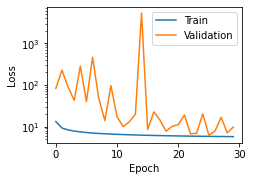

In [9]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.semilogy(log['epoch'], log['loss'], label='Train')
ax.semilogy(log['epoch'], log['val_loss'], label='Validation')

ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

*Finding*: Huge variance in validation loss is indicative of overfitting

Plot the performance on the test set

In [10]:
results = pd.read_csv(os.path.join(model['path'], 'test_predictions.csv'))

In [11]:
for m in ['r2_score', 'mean_squared_error', 'mean_absolute_error']:
    v = getattr(metrics, m)(results['y_true'], results['y_pred'])
    print(f'{m}: {v: .2f}')

r2_score:  1.00
mean_squared_error:  6.13
mean_absolute_error:  1.82


Plot the true vs predicted

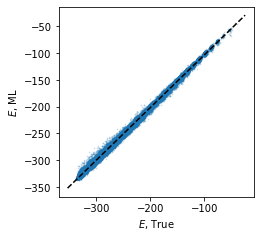

In [12]:
fig, ax = plt.subplots()

ax.scatter(results['y_true'], results['y_pred'], s=0.5, alpha=0.2)

ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--')
ax.set_xlabel('$E$, True')
ax.set_ylabel('$E$, ML')

fig.set_size_inches(3.5, 3.5)

Plot only the largest cluster size

In [13]:
subset = results.query(f'n_waters == {results["n_waters"].max()}')
print(f'Scores for the {len(subset)} largest molecules with {results["n_waters"].max()} waters')
for m in ['r2_score', 'mean_squared_error', 'mean_absolute_error']:
    v = getattr(metrics, m)(subset['y_true'], subset['y_pred'])
    print(f'{m}: {v: .2f}')

Scores for the 12333 largest molecules with 30 waters
r2_score:  0.36
mean_squared_error:  10.41
mean_absolute_error:  2.39


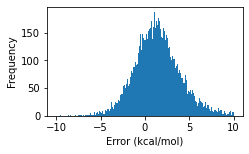

In [14]:
fig, ax = plt.subplots()

errors = subset['y_pred'] - subset['y_true']
bins = np.linspace(-10, 10, 256)
ax.hist(errors, bins=bins, density=False)

ax.set_xlabel('Error (kcal/mol)')
ax.set_ylabel('Frequency')
fig.set_size_inches(3.5, 2)

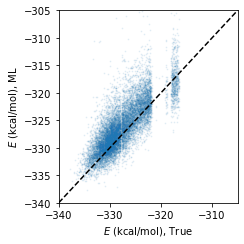

In [15]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.scatter(subset['y_true'], subset['y_pred'], s=0.5, alpha=0.1)

ax.set_ylim(-340, -305)
ax.set_xlim(ax.get_ylim())
ax.set_ylim(ax.get_xlim())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
ax.set_xlabel('$E$ (kcal/mol), True')
ax.set_ylabel('$E$ (kcal/mol), ML')

fig.tight_layout()

### Atomic Network
See how we did for the "node per atom" network

In [16]:
model = model_info.query('network_choice=="atomic"').sort_values('mean_absolute_error').iloc[0]
print(f'Model being evaluated: {model["path"]}')

Model being evaluated: train-keras/lambda3-T32-f64-N32-be165f


In [17]:
model[['path', 'network_choice', 'activation', 'message_steps', 'dropout', 'features', 'batch_size']]

path              train-keras/lambda3-T32-f64-N32-be165f
network_choice                                    atomic
activation                                      softplus
message_steps                                         32
dropout                                                0
features                                              64
batch_size                                          1024
Name: 33, dtype: object

In [18]:
model[['loss', 'val_loss', 'mean_squared_error']]

loss                  1.41449
val_loss              1.95186
mean_squared_error     1.9853
Name: 33, dtype: object

Plot the logs

In [19]:
log = pd.read_csv(os.path.join(model['path'], 'log.csv'))

Text(0, 0.5, 'Loss')

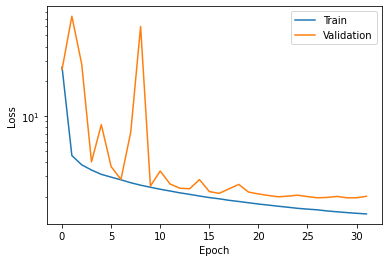

In [20]:
fig, ax = plt.subplots()

ax.semilogy(log['epoch'], log['loss'], label='Train')
ax.semilogy(log['epoch'], log['val_loss'], label='Validation')

ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

*Finding*: Huge variance in validation loss is indicative of overfitting

Plot the performance on the test set

In [21]:
results = pd.read_csv(os.path.join(model['path'], 'test_predictions.csv'))

In [22]:
for m in ['r2_score', 'mean_squared_error', 'mean_absolute_error']:
    v = getattr(metrics, m)(results['y_true'], results['y_pred'])
    print(f'{m}: {v: .2f}')

r2_score:  1.00
mean_squared_error:  1.99
mean_absolute_error:  1.03


Plot the true vs predicted

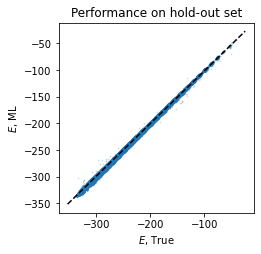

In [23]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.set_title('Performance on hold-out set')
ax.scatter(results['y_true'], results['y_pred'], s=0.5, alpha=0.2)

ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--')
ax.set_xlabel('$E$, True')
ax.set_ylabel('$E$, ML')

fig.set_size_inches(3.5, 3.5)

Plot only the largest cluster size

In [24]:
subset = results.query(f'n_waters == {results["n_waters"].max()}')
print(f'Scores for the {len(subset)} largest molecules with {results["n_waters"].max()} waters')
for m in ['r2_score', 'mean_squared_error', 'mean_absolute_error']:
    v = getattr(metrics, m)(subset['y_true'], subset['y_pred'])
    print(f'{m}: {v: .2f}')

Scores for the 12333 largest molecules with 30 waters
r2_score:  0.84
mean_squared_error:  2.62
mean_absolute_error:  1.16


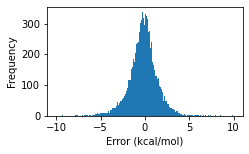

In [25]:
fig, ax = plt.subplots()

errors = subset['y_pred'] - subset['y_true']
bins = np.linspace(-10, 10, 256)
ax.hist(errors, bins=bins, density=False)

ax.set_xlabel('Error (kcal/mol)')
ax.set_ylabel('Frequency')
fig.set_size_inches(3.5, 2)

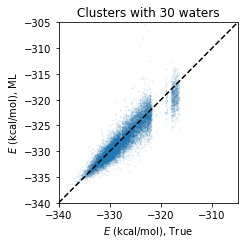

In [26]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.set_title('Clusters with 30 waters')
ax.scatter(subset['y_true'], subset['y_pred'], s=0.5, alpha=0.1)

ax.set_ylim(-340, -305)
ax.set_xlim(ax.get_ylim())
ax.set_ylim(ax.get_xlim())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
ax.set_xlabel('$E$ (kcal/mol), True')
ax.set_ylabel('$E$ (kcal/mol), ML')

fig.tight_layout()

Make a publication-ready figure

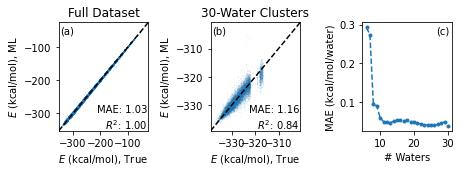

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(6.5, 2.5))

# Predicted vs actual plots
n_waters = results["n_waters"].max()
subset = results.query(f'n_waters == {n_waters}')
for d, ax, title in zip([results, subset], axs,
                        ['Full Dataset', '30-Water Clusters']):
    ax.set_title(title)
    ax.scatter(d['y_true'], d['y_pred'], s=0.7, alpha=0.2, edgecolor='none')

    max_ = max(ax.get_xlim()[1], ax.get_ylim()[1])
    min_ = min(ax.get_xlim()[0], ax.get_ylim()[0])
    ax.set_xlim([min_, max_])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
    ax.set_xlabel('$E$ (kcal/mol), True')
    ax.set_ylabel('$E$ (kcal/mol), ML')
    
    mae = metrics.mean_absolute_error(d['y_true'], d['y_pred'])
    r2 = metrics.r2_score(d['y_true'], d['y_pred'])
    ax.text(0.99, 0, f'MAE: {mae:.2f}\n$R^2$: {r2:.2f}',
            ha='right', va='bottom', transform=ax.transAxes,
            fontsize=10)
    
# Box and wisker plot
ax = axs[2]
error_stats = []
for s, subset in results.groupby('n_waters'):
    error = np.abs(subset['y_pred'] - subset['y_true']) / s
    error_stats.append({'size': s, 'mae': error.mean()})
error_stats = pd.DataFrame(error_stats)
ax.plot(error_stats['size'], error_stats['mae'], '--o', ms=3)
ax.set_xlabel('# Waters')
ax.set_ylabel('MAE (kcal/mol/water)')

# Add figure labels
for ax, l in zip(axs[:2], ['a', 'b']):
    ax.text(0.02, 0.9, f'({l})', transform=ax.transAxes)
axs[2].text(0.82, 0.9, '(c)', transform=axs[2].transAxes)
    
fig.tight_layout()
fig.savefig(os.path.join('figures', 'mpnn-performance.png'), dpi=320)

## Make the Box Plot
To match Jenna's

In [28]:
results['abs_error_per_water'] = np.abs(results['y_true'] - results['y_pred']) / results['n_waters']

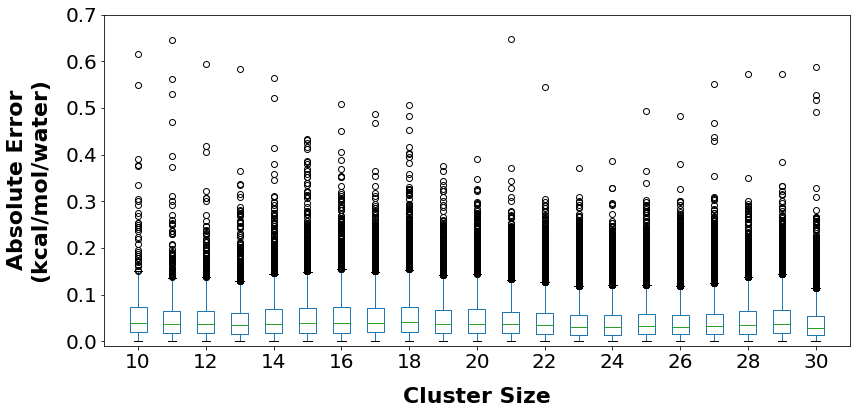

In [29]:
def make_box_plot(df, metric='abs_error_per_water'):       
    boxplot = df.query('n_waters >= 10 and n_waters <= 30').boxplot(metric, 'n_waters', grid=False, fontsize=20, figsize=(12,6), return_type='both')
    plt.ylim(-0.01,0.7)
    plt.ylabel('Absolute Error\n(kcal/mol/water)', fontsize=22, fontweight='bold', labelpad=15)
    plt.xlabel('Cluster Size', fontsize=22, fontweight='bold', labelpad=15)
    plt.xticks(range(1,23,2), ['10','12','14','16','18','20','22','24','26','28','30'])
    plt.xlim(0, 22)
    plt.suptitle('')
    plt.title('')
    plt.tight_layout()
    plt.savefig('figures/mpnn_boxplot-horz.png',dpi=600)
make_box_plot(results)

## Evaluate Hyperparameter Sweeps
We did some manual hyperparameter tuning for the atomic model

### Batch Sizes
Evaluate different batch sizes to get a tradeoff between accuracy and using the full GPU

In [30]:
base_query = ('epochs==32 and shuffle_buffer_size==2097152 and activation=="sigmoid" '
              'and message_steps==4 and network_choice=="atomic" and dropout==0 and features==64')

In [31]:
model_info.query(base_query).sort_values('val_loss')[['batch_size', 'loss', 'val_loss', 'mean_squared_error', 'epoch_time']]

,batch_size,loss,val_loss,mean_squared_error,epoch_time
2,1024,19.363194,19.398678,19.251877,306.585818
17,2048,19.376310,19.407209,19.257725,288.678715
8,256,19.403006,19.426159,19.270430,422.835339
34,512,19.405556,19.437868,19.277954,346.277758
7,1024,19.442961,19.541842,19.392525,313.491092
4,128,19.724388,19.677641,19.527553,585.525367
27,32,19.970613,19.757389,19.600475,1918.379986
9,64,19.823885,19.820322,19.651119,1040.957738


*Finding*: We get decent accuracy with a batch size of 1024 and still use 90% of the GPU

### Activation Function
We evaluated different activation functions for the message steps

In [32]:
base_query = ('batch_size==1024 and epochs==32 and shuffle_buffer_size==2097152 '
              'and message_steps==4 and network_choice=="atomic" and dropout==0 and features==64')

In [33]:
model_info.query(base_query).sort_values('mean_squared_error')[['activation', 'loss', 'val_loss', 'mean_squared_error', 'epoch_time']]

,activation,loss,val_loss,mean_squared_error,epoch_time
5,softplus,19.363789,19.398638,19.241763,304.652230
2,sigmoid,19.363194,19.398678,19.251877,306.585818
19,softplus,19.409700,19.432455,19.286464,314.062405
26,softmax,19.401388,19.439009,19.288677,315.037998
12,softsign,19.436844,19.462547,19.302105,314.516597
21,tanh,19.418333,19.471066,19.310736,312.946379
7,sigmoid,19.442961,19.541842,19.392525,313.491092


*Finding*: We should go with the softplus. Fastest and most accurate

### Number of Message Passing Layers
We compared increasing the number of message passing layers

In [34]:
base_query = ('hostname=="lambda3" and shuffle_buffer_size==2097152 and batch_size==1024 and activation=="softplus" and epochs==32 '
              'and network_choice=="atomic"')

In [35]:
model_info.query(base_query).sort_values('message_steps')[['network_choice', 'message_steps', 
                                                           'loss', 'val_loss', 'mean_squared_error',
                                                          'epoch_time']]

,network_choice,message_steps,loss,val_loss,mean_squared_error,epoch_time
3,atomic,1,31.174067,31.091873,31.005929,180.712310
20,atomic,2,27.901661,27.905479,27.782185,227.060249
5,atomic,4,19.363789,19.398638,19.241763,304.652230
19,atomic,4,19.409700,19.432455,19.286464,314.062405
23,atomic,8,5.878589,6.420089,6.385971,482.344306
28,atomic,16,3.091225,3.726466,3.722547,864.708338
33,atomic,32,1.414494,1.951858,1.985300,1551.005450


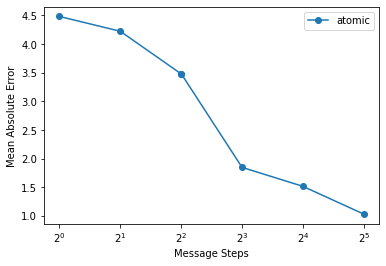

In [36]:
fig, ax = plt.subplots()

for label, subset in model_info.query(base_query).sort_values('message_steps').groupby('network_choice'):
    ax.plot(subset['message_steps'], subset['mean_absolute_error'], '-o', label=label)

ax.set_xscale('log', base=2)
ax.set_xlabel('Message Steps')
ax.set_ylabel('Mean Absolute Error')
ax.legend()

*Finding*: We need many message passing layers, which can get expensive